In [6]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
from sklearn.model_selection import train_test_split
import numpy as np
from copy import deepcopy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.manual_seed(1)
if device == 'cuda':
    torch.cuda.manual_seed_all(1)
print(device)

cuda


In [12]:
train_rawdata = datasets.MNIST(root = './data',
                               train=True,
                               download=False,
                               transform=transforms.ToTensor())
test_dataset = datasets.MNIST(root='./data',
                               train=False,
                               download=False,
                               transform=transforms.ToTensor())
print(f'number of training data : {len(train_rawdata)}')
print(f'number of test data : {len(test_dataset)}')

number of training data : 60000
number of test data : 10000


In [15]:
VALIDATION_RATE = 0.2 #코드 실행 도중 변경되지 않기를 기대하는 값 즉 고정값은 변수를 대문자로
train_indices, val_indices, _, _, = train_test_split( # 필요한 두 개(train_indices, val_indices)만 받고, 나머지 두 개는 _로 버림
    range(len(train_rawdata)), # X index 번호 # 인덱스 번호 (예: 0,1,2,...,59999) -> 이름표 달아주기
    train_rawdata.targets, # y # 각 데이터의 정답 라벨 (예: 5,0,4,...)
    stratify=train_rawdata.targets, # 균등분포, 라벨 비율 맞추기
    test_size=VALIDATION_RATE # test dataset 비율
)

train_dataset = Subset(train_rawdata, train_indices) # 	전체 데이터 중 학습용으로 사용할 일부만 골라서 새로운 학습용 데이터셋을 만든다
validation_dataset = Subset(train_rawdata, val_indices) # 동일
print(f'train dataset size : {len(train_dataset)}\nvalidation dataset size : {len(validation_dataset)}\ntest dataset size: {len(test_dataset)}')

minibatch_size = 128 # Mini-batch 사이즈는 128 로 설정

train_batches = DataLoader(train_dataset, batch_size=minibatch_size, shuffle=True)
val_batches = DataLoader(validation_dataset, batch_size=minibatch_size, shuffle=True)
test_batches = DataLoader(test_dataset, batch_size=minibatch_size, shuffle=True)

class CNNModel(nn.Module):
    def __init__(self):
        super().__init__()

        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 32,kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(32),
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(64),            
            nn.MaxPool2d(2),
            nn.Dropout(0.25),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.LeakyReLU(0.1),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2),
            nn.Dropout(0.25)
        )

        self.linear_layers = nn.Sequential(
            nn.Linear(3*3*128,128),
            nn.LeakyReLU(0.1),
            nn.BatchNorm1d(128),
            nn.Linear(128, 10),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, x): # x를 입력 받으면
        x = self.conv_layers(x) # 선언한 conv_layers를 통과 시키고,
        x = x.view(x.size(0), -1) # Flatten 
        x = self.linear_layers(x) # Flatten 시킨다음에 Classification 딥러닝 구조 linear_layers에 넘김
        return x
    
model = CNNModel().to(device)

loss_func = nn.NLLLoss() # log softmax 는 NLLLoss() 로 진행해야 함
optimizer = torch.optim.Adam(model.parameters())

def train_model(model, early_stop, n_epochs, progress_interval):
    train_losses, valid_losses, lowest_loss = list(), list(), np.inf # np.inf는 무한대(infinity) 를 의미 -> 처음엔 아무 loss보다도 큰 값으로 시작해라. 그래야 처음 loss는 무조건 더 작아서 갱신됨
    for epoch in tqdm(range(n_epochs), desc='Epoch Progress'):
        train_loss, valid_loss = 0,0 # 에폭마다 새롭게 train/validation 손실을 0부터 시작해서 누적 계산하겠다는 뜻
        model.train() # prepare for training
        for x_minibatch, y_minibatch in train_batches:
            x_minibatch = x_minibatch.to(device)
            y_minibatch = y_minibatch.to(device)
            #print(x_minibatch.shape, y_minibatch.shape)
            y_minibatch_pred = model(x_minibatch)
            loss = loss_func(y_minibatch_pred, y_minibatch)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        train_loss = train_loss/len(train_batches) # 전체 평균 loss = 누적합 / 배치 수
        train_losses.append(train_loss)

        # validation model
        model.eval()
        with torch.no_grad():
            for x_minibatch, y_minibatch in val_batches:
                x_minibatch = x_minibatch.to(device)
                y_minibatch = y_minibatch.to(device)
                y_minibatch_pred = model(x_minibatch)
                loss = loss_func(y_minibatch_pred, y_minibatch)
                valid_loss += loss.item()
                
        valid_loss = valid_loss / len(val_batches)
        valid_losses.append(valid_loss)

        if valid_losses[-1] < lowest_loss:
            lowest_loss = valid_losses[-1] # 더 낮은 validation loss 발견 (이번 epoch의 검증 손실)
            lowest_epoch = epoch # 몇 번째 epoch인지 기억
            best_model = deepcopy(model.state_dict()) # 그때 모델 저장
        else:
            if (early_stop > 0) and lowest_epoch + early_stop < epoch: #patience(=early_stop)만큼 기다렸다가 그래도 개선 안 되면 break로 멈춤 (early stopping)
                print ("Early Stopped", epoch, "epochs")
                break
                
        if (epoch % progress_interval) == 0: #  일정 간격마다 지금 학습 상태를 출력
            #print (train_losses[-1], valid_losses[-1], lowest_loss, lowest_epoch, epoch)
            print(f"[Epoch {epoch}] train loss: {train_losses[-1]:.6f}, valid loss: {valid_losses[-1]:.6f}, lowest loss: {lowest_loss:.6f} (lowest epoch {lowest_epoch})")
            
    model.load_state_dict(best_model) # 학습이 끝나면, 가장 좋은 성능을 냈던 모델(best_model)을 다시 불러옴        
    return model, lowest_loss, train_losses, valid_losses

nb_epochs = 100
progress_interval = 10
early_stop = 30

model, lowest_loss, train_losses, valid_losses = train_model(model, early_stop, nb_epochs, progress_interval)



train dataset size : 48000
validation dataset size : 12000
test dataset size: 10000


Epoch Progress:   0%|          | 0/100 [00:00<?, ?it/s]

Epoch Progress:   1%|          | 1/100 [00:08<14:44,  8.93s/it]

[Epoch 0] train loss: 0.133892, valid loss: 0.041635, lowest loss: 0.041635 (lowest epoch 0)


Epoch Progress:  11%|█         | 11/100 [01:47<14:07,  9.52s/it]

[Epoch 10] train loss: 0.013218, valid loss: 0.025844, lowest loss: 0.025828 (lowest epoch 8)


Epoch Progress:  21%|██        | 21/100 [03:19<13:22, 10.16s/it]

[Epoch 20] train loss: 0.007094, valid loss: 0.028543, lowest loss: 0.025828 (lowest epoch 8)


Epoch Progress:  31%|███       | 31/100 [05:06<12:30, 10.87s/it]

[Epoch 30] train loss: 0.005984, valid loss: 0.030533, lowest loss: 0.025828 (lowest epoch 8)


Epoch Progress:  39%|███▉      | 39/100 [06:46<10:35, 10.42s/it]

Early Stopped 39 epochs


In [16]:
test_loss = 0
correct = 0
wrong_samples, wrong_preds, actual_preds = list(), list(), list() # 테스트 손실값 누적용, 정답 개수, 틀린 예시를 저장할 변수들을 초기화

model.eval() #  모델을 평가 모드로 설정
with torch.no_grad(): # 평가할 때는 gradient 계산이 필요 없으니 꺼줌
    for x_minibatch, y_minibatch in test_batches: # 테스트셋을 미니배치 단위로 반복
        x_minibatch = x_minibatch.to(device)
        y_minibatch = y_minibatch.to(device)      
        y_test_pred = model(x_minibatch)
        test_loss += loss_func(y_test_pred, y_minibatch)  
        pred = torch.argmax(y_test_pred, dim=1) #  모델 출력 중 가장 확신하는 클래스(index) 를 선택
        correct += pred.eq(y_minibatch).sum().item() # 예측(pred)과 실제 정답(y_minibatch)을 비교해서 맞춘 개수 누적
        
        wrong_idx = pred.ne(y_minibatch).nonzero()[:, 0].cpu().numpy().tolist() # 틀린 샘플의 인덱스를 뽑기
        for index in wrong_idx:
            wrong_samples.append(x_minibatch[index].cpu()) # 입력 이미지
            wrong_preds.append(pred[index].cpu()) # 모델 예측
            actual_preds.append(y_minibatch[index].cpu()) # 실제 정답
            
test_loss /= len(test_batches.dataset) # 평균 loss 출력 (소수점 4자리까지)
print('Average Test Loss: {:.4f}'.format( test_loss ))
print('Accuracy: {}/{} ({:.2f}%)'.format( correct, len(test_batches.dataset), 100 * correct / len(test_batches.dataset) ))    

Average Test Loss: 0.0001
Accuracy: 9947/10000 (99.47%)


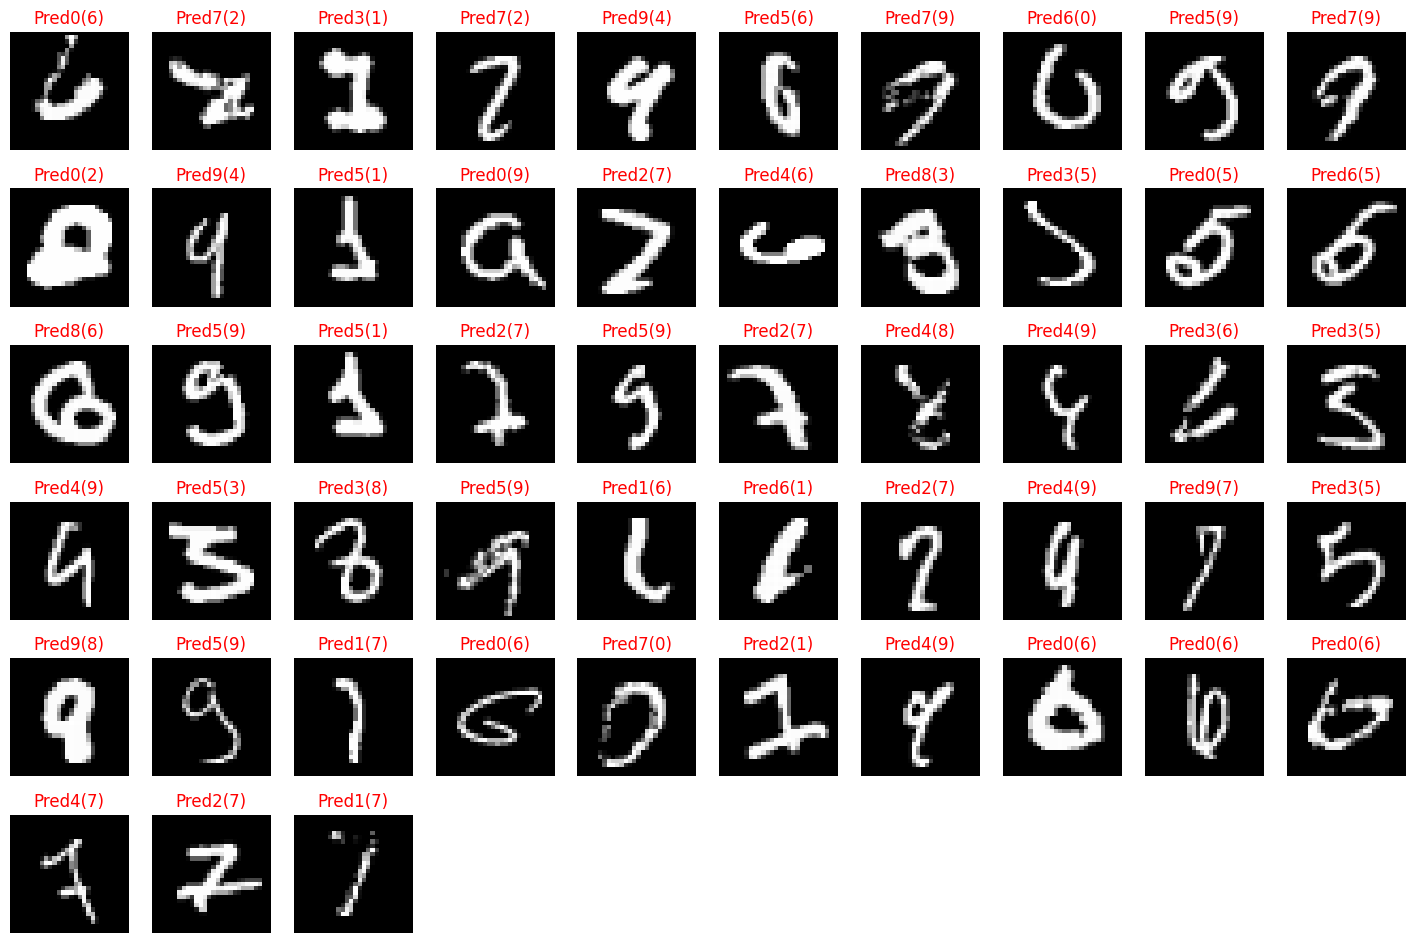

In [23]:
%matplotlib inline 

# plt.figure(figsize=(18 , 20))

# for index in range(10):
#     plt.subplot(10, 10, index + 1)
#     plt.axis('off')
#     plt.imshow(wrong_samples[index].numpy().reshape(28,28), cmap = "gray")
#     plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')

num_wrong = len(wrong_samples)  # ← 이 한 줄만 추가

plt.figure(figsize=(18 , 20))

for index in range(num_wrong):  # ← 여기를 100 → num_wrong 으로만 바꿈
    plt.subplot(10, 10, index + 1)
    plt.axis('off')
    plt.imshow(wrong_samples[index].numpy().reshape(28,28), cmap="gray")
    plt.title("Pred" + str(wrong_preds[index].item()) + "(" + str(actual_preds[index].item()) + ")", color='red')